In [1]:
%%bash
mkdir -p "./data/outputs"

In [2]:
import numpy as np
import pandas as pd
from hicpap import paptools

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=50)


* Case 1
    ```
    pearson_np = paptools.read_pearson(
        pearson="./data/juicer_data/gm12878_1000000_pearson_chr1.txt",
        format="juicer"
    )
    ```

* Case 2, It will takes a few minites. <br>
    https://aidenlab.org/data.html

    ```
    pearson_np = paptools.straw_to_pearson(
        hic_path="https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic",
        chrom_x="1",
        chrom_y="1",
        resolution=1000000,
        norm="KR",
        method="oe",
    )
    ```

* Case3, You already have your own pearson matrix in numpy.
    ```
    pearson_np = np.array([
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ])
    pearson_np = paptools.zero_means_pearson(pearson_np=pearson_np)
    ```


In [3]:
# Case 1
pearson_np = paptools.read_pearson(
    pearson="./data/juicer_data/gm12878_1000000_pearson_chr1.txt",
    format="juicer"
)

print(f"Pearson_np:\n {pearson_np}\n")

pearson_zero_np = paptools.zero_means_pearson(pearson_np=pearson_np)

print("Means of the first 3 rows of pearson_zero_np:")
print(np.round(np.mean(pearson_zero_np[0])))
print(np.round(np.mean(pearson_zero_np[1])))
print(np.round(np.mean(pearson_zero_np[2])))


Pearson_np:
 [[ 1.      0.146  -0.0449 ... -0.0375  0.4059  0.8426]
 [ 0.146   1.      0.4182 ... -0.4695 -0.582  -0.3026]
 [-0.0449  0.4182  1.     ... -0.5289 -0.4666 -0.3355]
 ...
 [-0.0375 -0.4695 -0.5289 ...  1.      0.8141  0.4091]
 [ 0.4059 -0.582  -0.4666 ...  0.8141  1.      0.7728]
 [ 0.8426 -0.3026 -0.3355 ...  0.4091  0.7728  1.    ]]

Means of the first 3 rows of pearson_zero_np:
0.0
0.0
0.0


In [4]:
output = "./data/outputs/gm12878_1000000_approx_pc1_chr1.txt"
approx_np = paptools.create_approx(pearson_np=pearson_np, output=output)
print(f"approx_np: {approx_np}")

approx_np: [ 0.1182 -0.3513 -0.2252 ...  0.2936  0.3887  0.2949]


In [5]:
# Flip track through GC content
def flip_track_gc(track_np: np.ndarray, gc_np: np.ndarray) -> np.ndarray:
    if np.mean(gc_np[track_np > 0]) < np.mean(gc_np[track_np < 0]):
        track_np = -track_np
    return track_np

gc_df = pd.read_table("./data/reference_gc/hg19/hg19_gc1000000_chr1.txt", skiprows=[0], names=["bin", "GC"])
gc_np = gc_df["GC"].values.flatten()
approx_np = approx_np[:-1]
approx_np = flip_track_gc(track_np=approx_np, gc_np=gc_np)
print(f"Flipped approx_np: {approx_np}")

Flipped approx_np: [-0.1182  0.3513  0.2252 ...  0.0107 -0.2936 -0.3887]


Heatmap

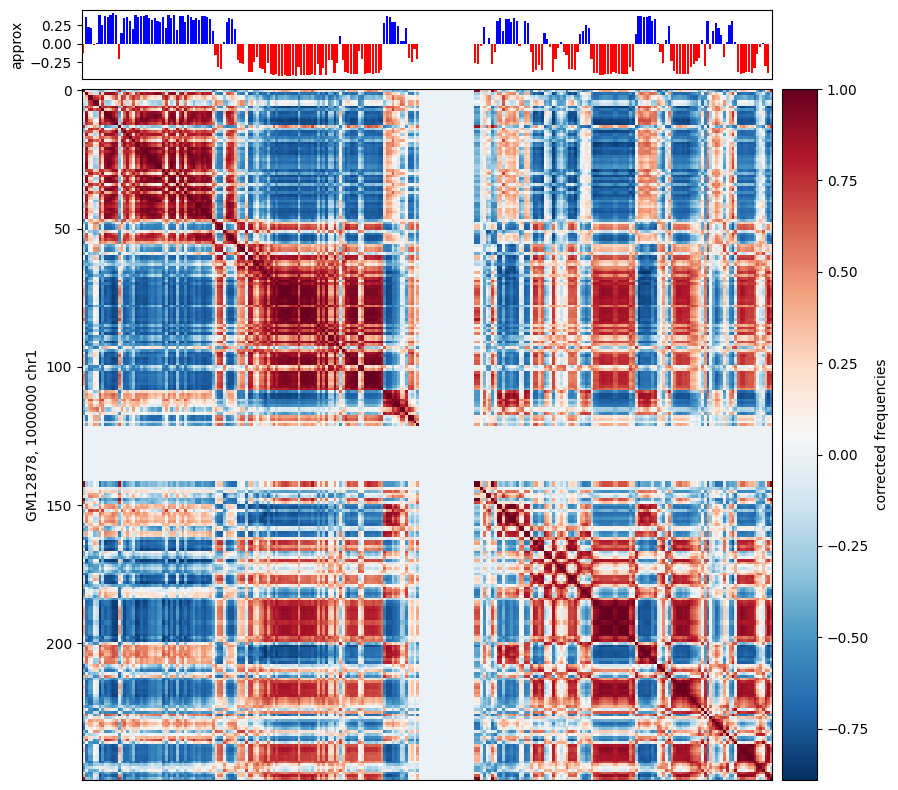

In [6]:
cell_line = "GM12878"
resolution = 1000000
chrom = "1"

f, ax = plt.subplots(
    figsize=(15, 10),
)

im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies')
ax.set_ylabel(f'{cell_line}, {resolution} chr{chrom}')
ax.xaxis.set_visible(False)

ax = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
approx_x_axis = [i for i in range(0, len(approx_np))]
approx_bar_color = ['b' if i > 0 else 'r' for i in approx_np]
ax.bar(x=approx_x_axis, height=approx_np, color=approx_bar_color)
ax.set_ylabel('approx')
ax.xaxis.set_visible(False)

In [7]:
del f, im, ax

Bonus

In [8]:
Vh, explained_variances, total_entry_num, valid_entry_num = paptools.pca_on_pearson(pearson_np=pearson_np)
pc1_np = Vh[0]
pc2_np = Vh[1]
pc3_np = Vh[2]

print(f"pc1_np: {pc1_np}")
print(f"pc2_np: {pc2_np}")
print(f"pc3_np: {pc3_np}")
print(f"explained_variances: {explained_variances}")
print(f"total_entry_num: {total_entry_num}")
print(f"valid_entry_num: {valid_entry_num}")

pc1_np: [-0.0241  0.0759  0.0487 ... -0.0633 -0.083  -0.0624]
pc2_np: [-0.0536 -0.0055 -0.1206 ...  0.0592 -0.0076 -0.0192]
pc3_np: [ 0.1081  0.0879 -0.0366 ...  0.039   0.0504  0.0846]
explained_variances: [0.8449 0.0699 0.0404 ... 0.     0.     0.    ]
total_entry_num: 250
valid_entry_num: 230


In [9]:
pc1_np = pc1_np[:-1]
pc1_np = flip_track_gc(track_np=pc1_np, gc_np=gc_np)
similarity_info = paptools.calc_similarity(pc1_np=pc1_np, approx_np=approx_np)
print(similarity_info)

# Compare with juicer pc1
juicer_pc1 = "./data/juicer_data/gm12878_1000000_pc1_chr1.txt"
juicer_pc1_df = pd.read_table(juicer_pc1, header=None)
juicer_pc1_np = juicer_pc1_df.fillna(0).values.flatten()

juicer_pc1_np = juicer_pc1_np[:-1]
juicer_pc1_np = flip_track_gc(track_np=juicer_pc1_np, gc_np=gc_np)
similarity_info = paptools.calc_similarity(pc1_np=juicer_pc1_np, approx_np=approx_np)
print(similarity_info)

{'total_entry_num': 249, 'valid_entry_num': 229, 'similar_num': 227, 'similar_rate': 0.9912663755458515}
{'total_entry_num': 249, 'valid_entry_num': 229, 'similar_num': 224, 'similar_rate': 0.9781659388646288}


In [10]:
paptools.plot_comparison(
    pc1_np=pc1_np,
    approx_np=approx_np,
    figsize=20,
    scatter="./data/outputs/gm12878_1000000_chr1_scatter.png",
    relative_magnitude="./data/outputs/gm12878_1000000_chr1_relative_magnitude.png"
)

Output:

> scatter
![scatter](./data/outputs/gm12878_1000000_chr1_scatter.png)

> relative_magnitude
![relative_magnitude](./data/outputs/gm12878_1000000_chr1_relative_magnitude.png)

{'total_entry_num': 249, 'valid_entry_num': 229, 'similar_num': 227, 'similar_rate': 0.9912663755458515}


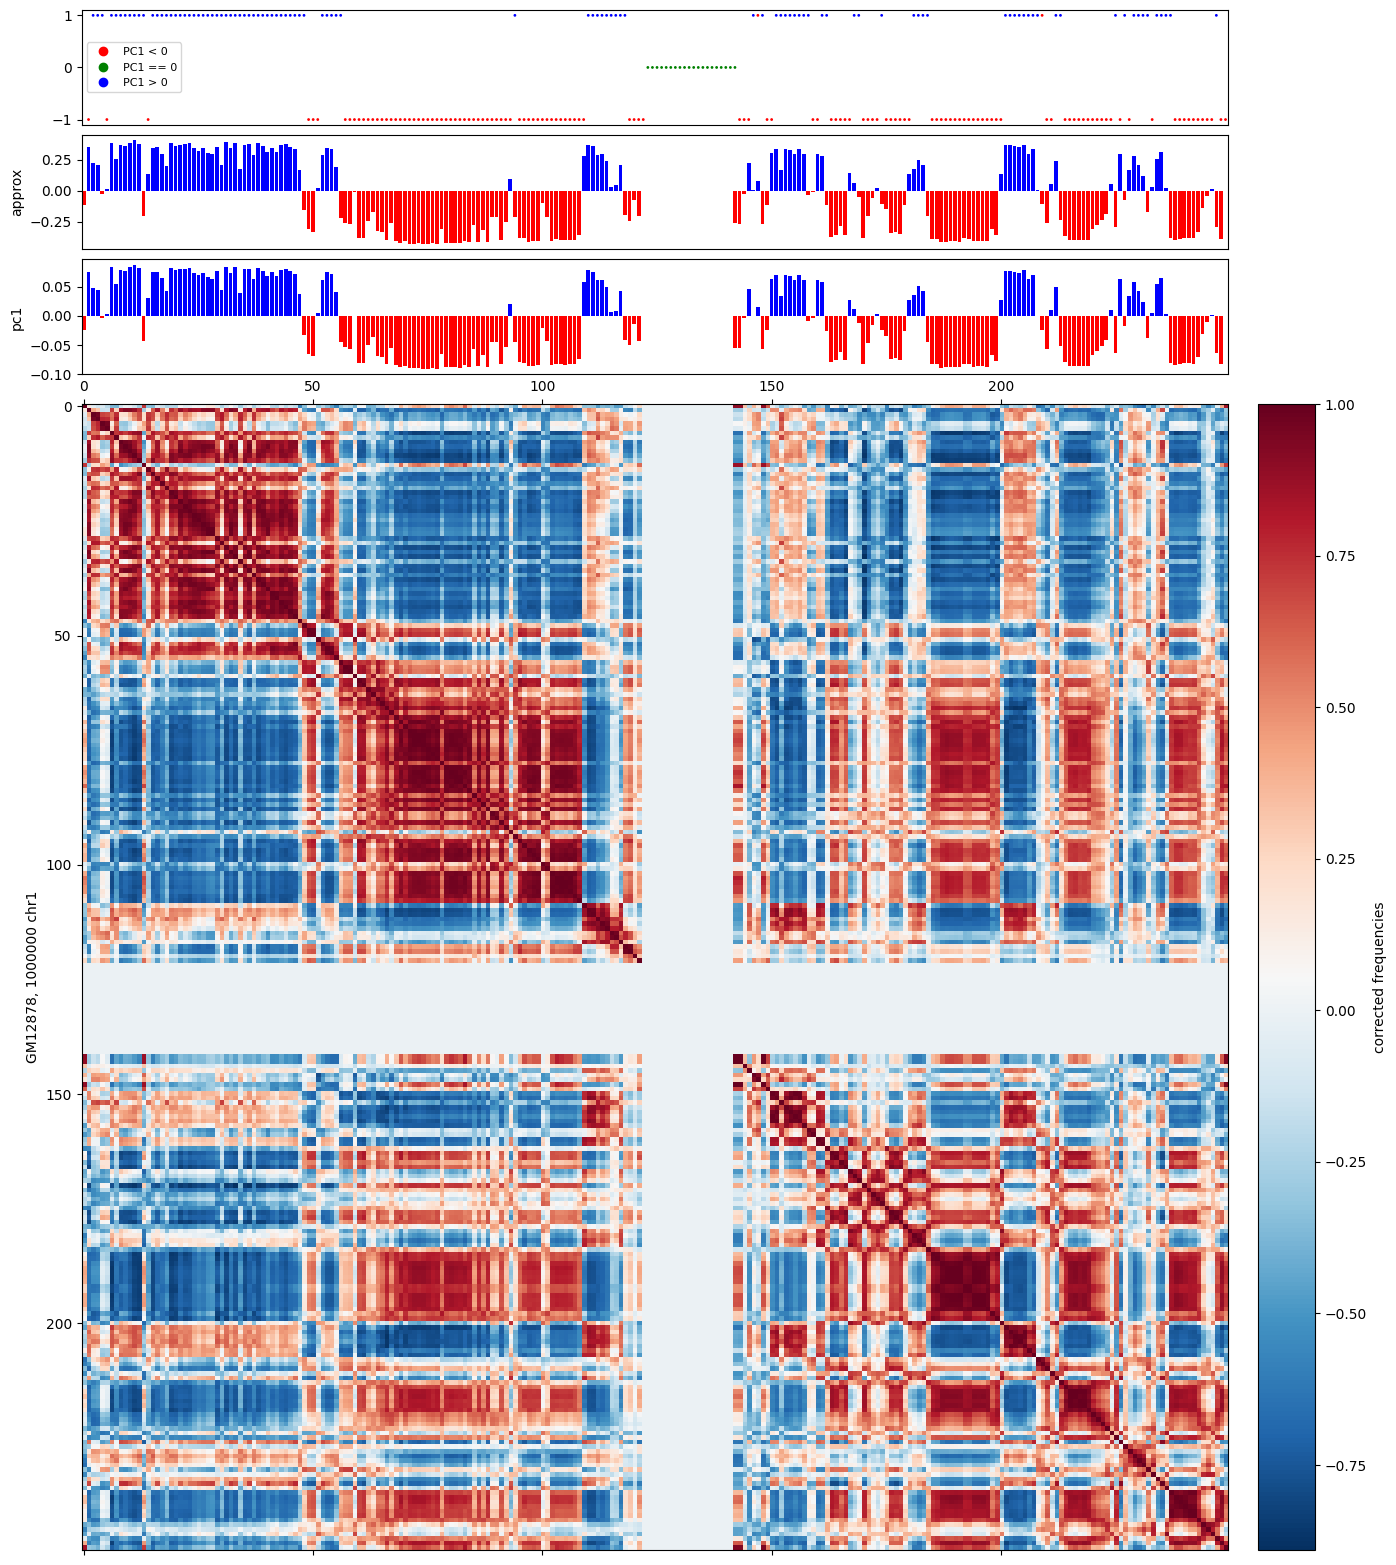

In [11]:
# Settings for pearson_np
f, ax = plt.subplots(
    figsize=(20, 20),
)
im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)
plt.colorbar(im, cax=cax, label='corrected frequencies')
ax.set_ylabel(f'{cell_line}, {resolution} chr{chrom}')

#### Settings for pc1_np
ax1 = divider.append_axes("top", size="10%", pad=0.3, sharex=ax)
pc1_x_axis = [i for i in range(0, len(pc1_np))]
pc1_bar_color = ['b' if i > 0 else 'r' for i in pc1_np]
ax1.bar(x=pc1_x_axis, height=pc1_np, color=pc1_bar_color)
ax1.set_ylabel('pc1')
ax1.xaxis.set_visible(False)

#### Settings for approx_np
ax2 = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
approx_x_axis = [i for i in range(0, len(approx_np))]
approx_bar_color = ['b' if i > 0 else 'r' for i in approx_np]
ax2.bar(x=approx_x_axis, height=approx_np, color=approx_bar_color)
ax2.set_ylabel('approx')
ax2.xaxis.set_visible(False)

#### Settings for pc1_np vs approx_np
similarity_info = paptools.calc_similarity(pc1_np, approx_np)
total_entry_num = similarity_info["total_entry_num"]
print(similarity_info)
plot_x_axis = [i + 1 for i in range(total_entry_num)]
approx_dots = [1 if i > 0 else -1 if i < 0 else 0 for i in approx_np]
pc1_colors_values = [2 if i > 0 else 0 if i < 0 else 1 for i in pc1_np]
pc1_colors = ListedColormap(['r', 'g', 'b'])
scatter_labels = ["PC1 < 0", "PC1 == 0", "PC1 > 0"]

ax3 = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
scatter_config = ax3.scatter(plot_x_axis, approx_dots, c=pc1_colors_values, cmap=pc1_colors, s=1)
ax3.legend(handles=scatter_config.legend_elements()[0], labels=scatter_labels, fontsize="8", loc="center left")
ax3.xaxis.set_visible(False)